## Layer Earth crust model

In this model, we build a layered Earth crust model, with two anomalies: slow velocity and fast velocity. The mean velociy is the similar AK135 model.

## AK135 velocity model
| depth(km)  |  vp (km/s)  | vs (km/s)  | rho (kg/m$^3$) |
|----|----|----|----|
|   0.000,   |   5.8000,  |    3.4600,  |    2.7200 |
|  20.000,   |   5.8000,  |    3.4600,  |    2.7200 |
|  20.000,   |   6.5000,  |    3.8500,  |    2.9200 |
|  35.000,   |   6.5000,  |    3.8500,  |    2.9200 |
|  35.000,   |   8.0400,  |    4.4800,  |    3.3198 |
|  77.500,   |   8.0450,  |    4.4900,  |    3.3455 |
| 120.000,   |   8.0500,  |    4.5000,  |    3.3713 |

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import os
from util import *

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
out_dir = "models"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [100]:
f0 = 15
vp0 = 7 #km/s
dx, dt = calc_dx_dt(f0, vp0)
dy = dx
n_pml = 15
x_range = [0, 10]
y_range = [0, 5]
t_range = [0, np.sqrt((x_range[1] - x_range[0])**2 + (y_range[1] - y_range[0])**2)/vp0]
x = np.arange(x_range[0], x_range[1], dx)
y = np.arange(y_range[0], y_range[1], dy)
t = np.arange(t_range[0], t_range[1], dt)
nx = len(x)
ny = len(y)
nt = len(t)
rcv_depth = 12
src_depth = ny - 12
mask_extra_depth = 4
print("nx = {}, ny = {}, nt = {}".format(nx, ny, nt))
print("dx = {} km, dy = {} km, dt = {} s".format(dx, dy, dt))

nx = 150, ny = 75, nt = 504
dx = 0.06666666666666667 km, dy = 0.06666666666666667 km, dt = 0.003174603174603174 s


## source and receiver types:

| index | type |
| :---: | :---: |
|0 | $v_x$ |
|1 | $v_y$ |
|2 | $\sigma_{xx}$ |
|3 | $\sigma_{yy}$ |
|4 | $\sigma_{xy}$ |

In [101]:
src_type = [2]
rcv_type = [0]
src_amp = 1e5

In [102]:
def step_profile(x_range, y_range, step):
    y_step1 = np.round(np.arange(y_range[0], y_range[1]+step, step)/step) * step
    print(y_step1)
    vp_step1 = y_step1/(y_range[1]-y_range[0]) * (6.5-5) + 5
    vs_step1 = y_step1/(y_range[1]-y_range[0]) * (4.48-3.46) + 3.46
    rho_step1 = y_step1/(y_range[1]-y_range[0]) * (3.32-2.72) + 2.72
    
    y_step2 = y_step1 + (y_step1[1] - y_step1[0] - step/5)
    vp_step2 = vp_step1
    vs_step2 = vs_step1
    rho_step2 = rho_step1

    idy = np.argsort(np.hstack([y_step1, y_step2]))
    y_step = np.hstack([y_step1, y_step2])[idy]
    vp_step = np.hstack([vp_step1, vp_step2])[idy]
    vs_step = np.hstack([vs_step1, vs_step2])[idy]
    rho_step = np.hstack([rho_step1, rho_step2])[idy]
    vp_step[-1:] = vp_step[-2]
    vs_step[-1:] = vs_step[-2]
    rho_step[-1:] = rho_step[-2]
    
    return y_step, vp_step, vs_step, rho_step

def build_layer_model(x, y, step):
    y_step, vp_step, vs_step, rho_step = step_profile([x[0], x[-1]], [y[0], y[-1]], step)
    
    vp = interp1d(y_step, vp_step, kind='slinear')(y)
    vs = interp1d(y_step, vs_step, kind='slinear')(y)
    rho = interp1d(y_step, rho_step, kind='slinear')(y)
    
    vp = np.tile(vp[np.newaxis,:], [len(x),1])
    vs = np.tile(vs[np.newaxis,:], [len(x),1])
    rho = np.tile(rho[np.newaxis,:], [len(x),1])
    
    model = {}
    model['vp'] = vp
    model['vs'] = vs
    model['rho'] = rho
    model['x'] = x
    model['y'] = y
    model['dx'] = x[1] - x[0]
    model['dy'] = y[1] - y[0]
    
    return model

step = 1 #km
model = build_layer_model(x, y, step)


[0. 1. 2. 3. 4. 5.]


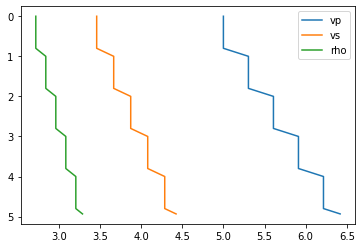

In [103]:
plt.figure()
plt.plot(model['vp'][0,:], y, label='vp')
plt.plot(model['vs'][0,:], y, label='vs')
plt.plot(model['rho'][0,:], y, label='rho')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [104]:
def add_source(nsrc, nx, nt, dt, f0=5, n_pml=0):
    src_list = []
#     src_ix = np.round(np.linspace(0+2*n_pml, nx-2*n_pml, nsrc)).astype('int')
#     src_iy = np.ones_like(src_ix) * src_depth
    src_ix = [nx//4] * nsrc
    src_iy = [ny*2//3] * nsrc
    src_vec = np.zeros(nt)
    vec = 1e7*ricker(f0, dt)
    src_vec[:len(vec)] = vec[:nt]
    for i in range(nsrc):
        tmp = {}
        tmp['ix'] = src_ix[i]
        tmp['iy'] = src_iy[i]
        tmp['type'] = 0
        tmp['vec'] = src_vec
        src_list.append(tmp)
    return src_list

nsrc = 1
source_list = add_source(nsrc, nx, nt, dt, f0, n_pml)

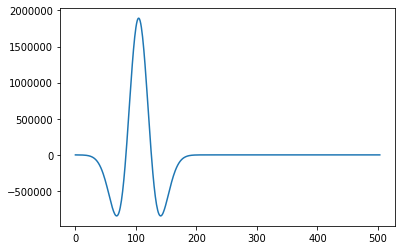

In [105]:
plt.figure()
plt.plot(source_list[0]['vec'])
plt.show()

In [106]:
def add_receiver(nrec, nsrc, nx, n_pml=0, types=[0]):
    rcv = {}
    rcv['ix'] = np.round(np.linspace(0+n_pml, nx-n_pml, nrec)).astype('int')
    rcv['iy'] = np.ones_like(rcv['ix']) * rcv_depth
    rcv['type'] = np.ones_like(rcv['ix'])
    
    rcvs = {}
    rcvs['ix'] = np.tile(rcv['ix'], len(types))   
    rcvs['iy'] = np.tile(rcv['iy'], len(types))  
    rcvs['type'] = np.hstack([rcv['type'] * i for i in types])
    
    return [rcvs] * nsrc
    
receiver_list = add_receiver(int(vp0/f0/dx)*4, nsrc, nx, n_pml, rcv_type)

In [107]:
def get_smooth_model(model, src):
#     vp = model['vp'].copy()
#     vp[:,rcv_depth+mask_extra_depth:src_depth-mask_extra_depth] = gaussian_filter(model['vp'][:, rcv_depth+mask_extra_depth:src_depth-mask_extra_depth], [10,10], mode='reflect')
#     vs = model['vs'].copy()
#     vs[:,rcv_depth+mask_extra_depth:src_depth-mask_extra_depth] = gaussian_filter(model['vs'][:, rcv_depth+mask_extra_depth:src_depth-mask_extra_depth], [10,10], mode='reflect')
#     rho = model['rho'].copy()
#     rho[:,rcv_depth+mask_extra_depth:src_depth-mask_extra_depth] = gaussian_filter(model['rho'][:, rcv_depth+mask_extra_depth:src_depth-mask_extra_depth], [10,10], mode='reflect')
    vp = model['vp'].copy()
    vp = gaussian_filter(model['vp'], [10,10], mode='reflect')
    vs = model['vs'].copy()
    vs = gaussian_filter(model['vs'], [10,10], mode='reflect')
    rho = model['rho'].copy()
    rho = gaussian_filter(model['rho'], [10,10], mode='reflect')
    
    new_model = {}
    new_model['vp'] = vp
    new_model['vs'] = vs
    new_model['rho'] = rho
    new_model['x'] = model['x']
    new_model['y'] = model['y']
    new_model['dx'] = model['dx']
    new_model['dy'] = model['dy']
    return new_model

smooth_model = get_smooth_model(model, source_list[0])

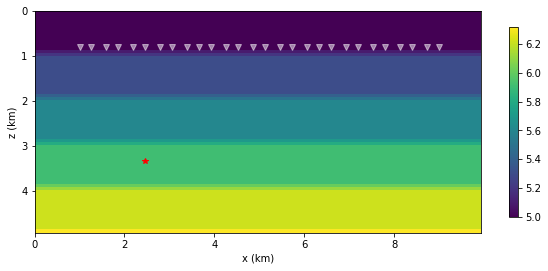

In [108]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]
plt.pcolormesh(x_mesh-x0, y_mesh, model['vp'].T)
plt.plot(x[receiver_list[0]['ix']]-x0, y[receiver_list[0]['iy']], 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]-x0, y[source_list[i]['iy']], 'r*', markersize=12)
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "layer-model-vp.png"))
plt.show()

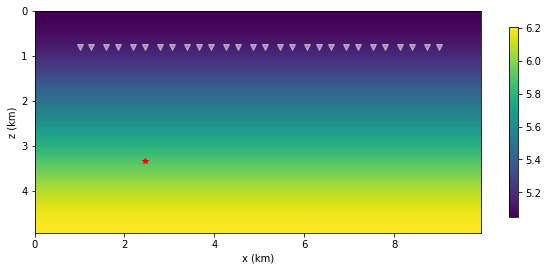

In [109]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]
plt.pcolormesh(x_mesh-x0, y_mesh, smooth_model['vp'].T)
plt.plot(x[receiver_list[0]['ix']]-x0, y[receiver_list[0]['iy']], 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]-x0, y[source_list[i]['iy']], 'r*', markersize=12)
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "layer-model-smooth-vp.png"))
plt.show()

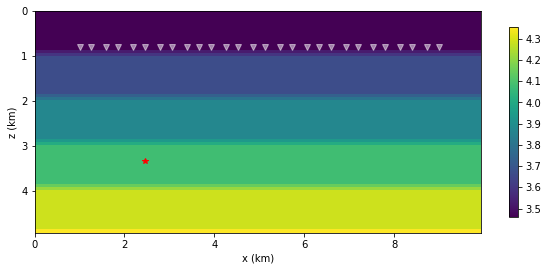

In [110]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]
plt.pcolormesh(x_mesh-x0, y_mesh, model['vs'].T)
plt.plot(x[receiver_list[0]['ix']]-x0, y[receiver_list[0]['iy']], 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]-x0, y[source_list[i]['iy']], 'r*', markersize=12)
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "layer-model-vs.png"))
plt.show()

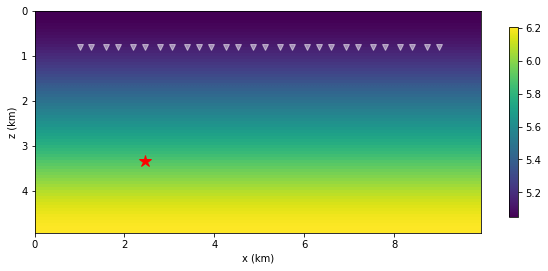

In [111]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]
plt.pcolormesh(x_mesh-x0, y_mesh, smooth_model['vp'].T)
plt.plot(x[receiver_list[0]['ix']]-x0, y[receiver_list[0]['iy']], 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]-x0, y[source_list[i]['iy']], 'r*', markersize=12)
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "layer-model-smooth-vp.png"))
plt.show()

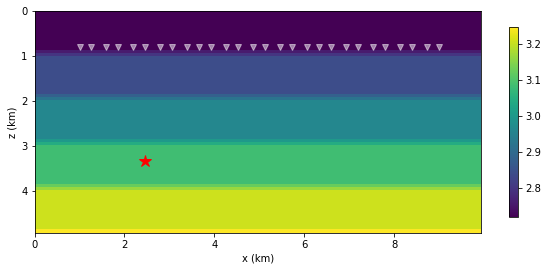

In [112]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]
plt.pcolormesh(x_mesh-x0, y_mesh, model['rho'].T)
plt.plot(x[receiver_list[0]['ix']]-x0, y[receiver_list[0]['iy']], 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]-x0, y[source_list[i]['iy']], 'r*', markersize=12)
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "layer-model-rho.png"))
plt.show()

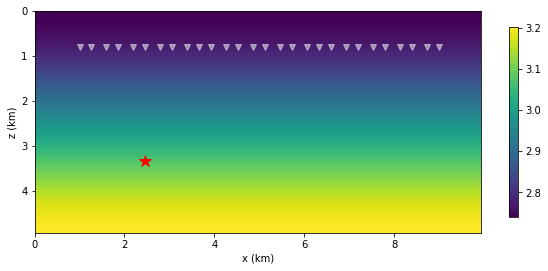

In [113]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]
plt.pcolormesh(x_mesh-x0, y_mesh, smooth_model['rho'].T)
plt.plot(x[receiver_list[0]['ix']]-x0, y[receiver_list[0]['iy']], 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]-x0, y[source_list[i]['iy']], 'r*', markersize=12)
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "layer-model-smooth-rho.png"))
plt.show()

In [114]:
scipy.io.savemat(os.path.join(out_dir, "layer-model-source-smooth.mat"), 
         {"vp" : smooth_model['vp'], 
         "vs" : smooth_model['vs'], 
         "rho" : smooth_model['rho'],
#          "vs" : anomaly_model['vs']*1000, 
#          "rho" : anomaly_model['rho']*1000,
         "source" : source_list,
         "receiver" : receiver_list,
         "dx" : dx,
         "dy" : dy,
         "dt" : dt,
         "nx" : nx,
         "ny" : ny,
         "nt" : nt,
         "f0" : f0})

In [115]:
scipy.io.savemat(os.path.join(out_dir, "layer-model-source.mat"), 
         {"vp" : model['vp'], 
         "vs" : model['vs'], 
         "rho" : model['rho'],
         "source" : source_list,
         "receiver" : receiver_list,
         "dx" : dx,
         "dy" : dy,
         "dt" : dt,
         "nx" : nx,
         "ny" : ny,
         "nt" : nt,
         "f0" : f0})